# OPENCLASSROOMS - PROJET 4
# ANALYSEZ LES VENTES DE VOTRE ENTREPRISE
-------------------------

# Retrouvez la version colorée sur <a href="https://bertrand4.github.io/OCP4_Analysez_les_ventes_de_votre_entreprise/" target="_blank">ce lien</a>.

## _Sommaire_

### Mission 1: Base de données - Préparatifs


#### I.Nettoyage des données
- I.1.Customers    
- I.2.Products    
- I.3.Transactions

#### II.Finalisation du support
- II.1.Jointure des trois tableaux de base
- II.2.Agrégations sur les mois
- II.3.Variables supplémentaires

### Mission 2: Analyses Graphiques


#### I.Étude du chiffre d'affaires
- I.1.Évolution globale du chiffre d'affaires
- I.2.Évolution mensuelle du chiffre d'affaires
- I.3.Observation du mois d'Octobre
- I.4.Catégories de livres par nombre de ventes et par chiffre d'affaires
- I.5.Catégories de livres: Mesures de tendance centrale
    
#### II.Statistiques de la clientèle
- I.1.Étude des âges
- I.2.Étude des genres
- I.3.Répartition du chiffre d'affaires par client, courbe de Lorenz et indice de Gini
- I.4.Proportions de clients actifs/inactifs
    
#### III.Statistiques des sessions d'achats
- III.1.Montants des sessions
- III.2.Taille du panier moyen
- III.3.Répartition du panier moyen
    
#### IV.Analyses des ventes et des prix
- IV.1.Bilan des prix
- IV.2.Vendus et invendus
- IV.3.Prix des invendus

### Mission 3: Étude des Corrélations


#### I.Préparatifs et optimisations pour les analyses
- I.1.Fonctions utilitaires
- I.2.Tableaux de support et suppression des Outliers
- I.3.Autres supports
    
#### II.Sexe des clients et catégories de produits achetés
- II.1.Tableau de contingence réel
- II.2.Tableau de contingence théorique
- II.3.Tableau de contingence coloré

#### III.Âge des clients et montant total des achats
- III.1.Diagramme de dispersion
- III.2.Tranches d'âges et montant total des achats
    
#### IV.Âge des clients et fréquences d'achats
- IV.1.Diagramme de dispersion
- IV.2.Tranches d'âges et fréquences d'achats

#### V.Âge des clients et taille du panier moyen
- V.1.Diagramme de dispersion
- V.2.Tranches d'âges et taille du panier moyen
    
#### VI.Âge des clients et catégories de produits achetés
- VI.1.Rapport de corrélation
- VI.2.Tableau de contingence coloré    

### Nous importons dans un premier temps l'ensemble des librairies nécessaires pour l'ensemble du projet.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import arange, plot
from matplotlib.pyplot import figure

import datetime as dt

import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

# Mission 1: Base de données - Préparatifs

# I. Nettoyage des données

## I.1. Customers

Ce premier DataFrame nous renvoie la liste des clients qui ont effectué des achats dans l'année, caractérisés par leur identifiant client, leur sexe et leur année de naissance.

In [17]:
customers = pd.read_csv("data/projet_4/base/customers.csv")
customers.head(5)

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


Pour ce premier DataFrame, nous remplacerons l'année de naissance des clients par leur âge, puis nous retirerons de la clist les clients 'test'.

In [18]:
customers["age"]=2022-customers.birth
customers=customers.drop(columns=["birth"])

customers=customers.loc[(customers["client_id"].isin(["ct_0", "ct_1"]))==False]

customers

,client_id,sex,age
0,c_4410,f,55
1,c_7839,f,47
2,c_1699,f,38
3,c_5961,f,60
4,c_5320,m,79
...,...,...,...
8618,c_7920,m,66
8619,c_7403,f,52
8620,c_5119,m,48
8621,c_5643,f,54


## I.2. Products

Ce deuxième DataFrame nous renvoie la liste des produits (livres) achetés au cours de l'année, indexés par leur identifiant de produit, leur prix, et la catégorie (0, 1 ou 2) auxquelles ils appartiennent.

In [19]:
products = pd.read_csv("data/projet_4/base/products.csv")
products.head(4)

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1


Repérons la petite valeur aberrante suivante: un des prix est négatif! Il s'agit d'un produit test. Nous allons donc l'enlever.

In [20]:
products[products.price<0]

,id_prod,price,categ
731,T_0,-1.0,0


In [21]:
products=products.loc[products["price"] > 0 ].reset_index(drop=True)
products

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0
...,...,...,...
3281,2_23,115.99,2
3282,0_146,17.14,0
3283,0_802,11.22,0
3284,1_140,38.56,1


## I.3. Transactions

Enfin, il nous reste la liste des transactions effectuées au cours de l'année, où l'on peut notamment y repérer quel client a acheté tel ou tel livre.

In [22]:
transactions = pd.read_csv("data/projet_4/base/transactions.csv")
transactions.head(2)

,id_prod,date,session_id,client_id
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277


Dans la cellule suivante, nous allons:
- Retirer les clients test.
- Nous débarasser des microsecondes (on y verra plus clair!)
- Faire un "split" de la date et de l'heure dans le cadre des analyses de la mission 2.

In [201]:
#Retrait des clients test:
transactions=transactions.loc[(transactions.client_id!='ct_0')&(transactions.client_id!='ct_1')]

#Bon débarras des microsecondes:
D=[]
for date in transactions["date"]:
    date_claire=date.split(".")[0]
    D.append(date_claire)   
transactions["date"]=D

#On renomme la colonne "date" en "date_et_heure" et on la convertit en datetime:
transactions.rename(columns={"date": "date_et_heure"}, inplace=True)
transactions["date_et_heure"]=pd.to_datetime(transactions["date_et_heure"])


#La conversion de date_et_heure en datetime nous permet d'appliquer les fonctions date() et time() sur cette variable qui nous
#renvoient respectivement la date et l'heure:
DATES, HEURES = [], []
for dh in transactions["date_et_heure"]:
    DATES.append(dh.date())
    HEURES.append(dh.time())

#Séparation de "date_et_heure" et suppression de cette dernière:
transactions["date"]=DATES
transactions["heure"]=HEURES
transactions=transactions.drop(columns="date_et_heure")

transactions

,id_prod,session_id,client_id,date,heure
0,0_1483,s_18746,c_4450,2021-04-10,18:37:28
1,2_226,s_159142,c_277,2022-02-03,01:55:53
2,1_374,s_94290,c_4270,2021-09-23,15:13:46
3,0_2186,s_105936,c_4597,2021-10-17,03:27:18
4,0_1351,s_63642,c_1242,2021-07-17,20:34:25
...,...,...,...,...,...
337011,1_671,s_40720,c_3454,2021-05-28,12:35:46
337012,0_759,s_50568,c_6268,2021-06-19,00:19:23
337013,0_1256,s_7219,c_4137,2021-03-16,17:31:59
337014,2_227,s_112349,c_5,2021-10-30,16:50:15


Enfin, vérifions s'il existe un produit présent dans "transactions" mais absent dans "products".

In [202]:
is_absent=transactions[transactions.id_prod.isin(products.id_prod)==False]["id_prod"].unique()[0]
is_absent

'0_2245'

Ne vous en faites pas, nous allons régler ça dans la partie suivante.

# II. Finalisation du support

## II.1. Jointure des trois tableaux de base

Nous créons maintenant le DataFrame "table", qui regroupera les trois DataFrames précédents traités et nettoyés. D'abord, on fait la jointure externe - afin de récupérer l'élément manquant dans products - de products et de transactions.

In [203]:
table = pd.merge(products, transactions, on='id_prod', how='outer')
table

,id_prod,price,categ,session_id,client_id,date,heure
0,0_1421,19.99,0.0,s_33709,c_7954,2021-05-12,23:26:29
1,0_1421,19.99,0.0,s_154957,c_254,2022-01-25,11:27:39
2,0_1421,19.99,0.0,s_144068,c_5770,2022-01-02,22:29:33
3,0_1421,19.99,0.0,s_2187,c_1455,2021-03-05,17:10:40
4,0_1421,19.99,0.0,s_13112,c_2768,2021-03-29,13:55:04
...,...,...,...,...,...,...,...
336833,0_2245,NaN,NaN,s_16936,c_4167,2021-04-06,19:59:19
336834,0_2245,NaN,NaN,s_13738,c_7790,2021-03-30,23:29:02
336835,0_2245,NaN,NaN,s_128815,c_6189,2021-12-03,14:14:40
336836,0_2245,NaN,NaN,s_26624,c_1595,2021-04-27,18:58:47


Avant d'ajouter les clients, traîtons les valeurs manquantes, jusque là:
- La colonne "categ", indique la catégorie de livres - 0, 1 ou 2 - qui se trouve être le premier chiffre de son identifiant produit "id_prod".
- La colonne "price" présente une valeur nulle les livres 0_2245. Après analyse des mesures de tendance centrale, on fixera ce prix à 9,99 euros.

In [204]:
#Fonction permettant de récupérer le premier chiffre d'un identifiant de produit dans nos données:
def get_categ(car):
    return  int(car.split("_")[0])

#Complétude de "categ":
table["categ"]=table.id_prod.apply(get_categ)

#Ajout du prix du livre 0_2245:
table["price"].fillna(9.99, inplace=True)

table.tail(3)

,id_prod,price,categ,session_id,client_id,date,heure
336835,0_2245,9.99,0,s_128815,c_6189,2021-12-03,14:14:40
336836,0_2245,9.99,0,s_26624,c_1595,2021-04-27,18:58:47
336837,0_2245,9.99,0,s_28235,c_5714,2021-05-01,03:35:03


On peut maintenant ajouter les données de "customers" à notre DataFrame par jointure interne et on le réindexe notre table selon les dates.

In [205]:
table=pd.merge(table, customers)

table.sort_values(by="date", inplace=True)
table=table.reset_index(drop=True)

table

,id_prod,price,categ,session_id,client_id,date,heure,sex,age
0,0_2007,9.99,0,s_201,c_6906,2021-03-01,10:06:06,m,36
1,0_2096,14.84,0,s_311,c_6823,2021-03-01,14:54:32,m,64
2,0_1627,3.99,0,s_72,c_6823,2021-03-01,02:58:10,m,64
3,2_108,63.36,2,s_314,c_5042,2021-03-01,15:03:55,m,27
4,1_446,23.92,1,s_109,c_5890,2021-03-01,04:34:54,m,65
...,...,...,...,...,...,...,...,...,...
336811,0_1152,10.70,0,s_172145,c_332,2022-02-28,10:31:46,f,49
336812,0_2134,5.57,0,s_171999,c_903,2022-02-28,03:26:03,f,59
336813,0_2293,4.99,0,s_171940,c_2048,2022-02-28,01:05:47,m,35
336814,0_1140,3.73,0,s_171986,c_8547,2022-02-28,02:43:12,f,45


Nous allons maintenant finaliser notre base de données, mais avant ça, quelques agrégations sur les mois de l'année s'imposent...

## II.2. Agrégations sur les mois

Dans le cadre des analyses graphiques à réaliser pour la mission 2, il sera intéressant d'étudier certaines variables selon les mois de l'année. Rappelons que notre étude futuriste s'étend de mars 2021 à février 2022. Le DataFrame suivant nous donne donc la liste des 12 mois de l'année, leur numéro de mois et leur "chronologie" dans notre étude (afin de pouvoir les classer en cas de besoin).

In [9]:
calendar=pd.DataFrame({"nom_mois": ["janvier", "fevrier", "mars", "avril", "mai", "juin",
                                    "juillet", "août", "septembre", "octobre", "novembre", "decembre"],
                       "numero_mois": range(1, 13),
                       "chronologie": [22.01, 22.02, 21.03, 21.04, 21.05, 21.06, 
                                        21.07, 21.08, 21.09, 21.10, 21.11, 21.12]})
calendar

,nom_mois,numero_mois,chronologie
0,janvier,1,22.01
1,fevrier,2,22.02
2,mars,3,21.03
3,avril,4,21.04
4,mai,5,21.05
5,juin,6,21.06
6,juillet,7,21.07
7,août,8,21.08
8,septembre,9,21.09
9,octobre,10,21.10


Et ici, les fonctions qui nous permettront de passer facilement du nom du mois à son numéro, vice et versa, et éventuellement à leur chronologie.

In [10]:
#Pour passer, par exemple, de "juillet" à 7:
def nom_mois(a):
    for i in calendar.index:
        if a==calendar.numero_mois[i]:
            return(str(calendar.nom_mois[i]))

#Pour passer, par exemple, de 4 à "avril":        
def nombre_mois(car):
    for i in calendar.index:
        if car==calendar.nom_mois[i]:
            return(float(calendar.numero_mois[i]))
        
def chronologie(car):
    for i in calendar.index:
        if car==calendar.nom_mois[i]:
            return(calendar.chronologie[i])

## II.3. Variables supplémentaires

Notons qu'une "session" est un groupe d'achats. Ce serait donc intéressant de savoir, combien de livres ont été achetés à chaque session. On crée donc la variable "basket_size" qui nous donnera cette indication.

In [208]:
table["basket_size"]=table["session_id"].value_counts()[table["session_id"]].tolist()
table.head(3)

,id_prod,price,categ,session_id,client_id,date,heure,sex,age,basket_size
0,0_2007,9.99,0,s_201,c_6906,2021-03-01,10:06:06,m,36,3
1,0_2096,14.84,0,s_311,c_6823,2021-03-01,14:54:32,m,64,2
2,0_1627,3.99,0,s_72,c_6823,2021-03-01,02:58:10,m,64,1


Enfin, en vue des analyses graphiques que nous ferons, avoir le mois en vigueur rendra notre codage bien plus propre.

In [209]:
#On reconverti la date en datetime:
table["date"]=pd.to_datetime(table["date"])

#On ajoute la colonne "mois" grâce à nos fonctions:
table["mois"]=table["date"].dt.month.apply(nom_mois)

#Et le jour du mois, ce sera utile:
table["jour"]=table["date"].dt.day

table

,id_prod,price,categ,session_id,client_id,date,heure,sex,age,basket_size,mois,jour
0,0_2007,9.99,0,s_201,c_6906,2021-03-01,10:06:06,m,36,3,mars,1
1,0_2096,14.84,0,s_311,c_6823,2021-03-01,14:54:32,m,64,2,mars,1
2,0_1627,3.99,0,s_72,c_6823,2021-03-01,02:58:10,m,64,1,mars,1
3,2_108,63.36,2,s_314,c_5042,2021-03-01,15:03:55,m,27,1,mars,1
4,1_446,23.92,1,s_109,c_5890,2021-03-01,04:34:54,m,65,1,mars,1
...,...,...,...,...,...,...,...,...,...,...,...,...
336811,0_1152,10.70,0,s_172145,c_332,2022-02-28,10:31:46,f,49,5,fevrier,28
336812,0_2134,5.57,0,s_171999,c_903,2022-02-28,03:26:03,f,59,1,fevrier,28
336813,0_2293,4.99,0,s_171940,c_2048,2022-02-28,01:05:47,m,35,7,fevrier,28
336814,0_1140,3.73,0,s_171986,c_8547,2022-02-28,02:43:12,f,45,1,fevrier,28


On finit cette première mission en réorganisant notre DataFrame histoire d'y voir plus clair et on est parti pour la mission 2!

In [210]:
#On réindexe notre support pour y voir plus clair:
table=table.reindex(columns=["id_prod", "categ", "price", 
                             "client_id", "sex", "age",
                             "session_id", "basket_size",
                             "date", "mois", "jour", "heure"])
table

,id_prod,categ,price,client_id,sex,age,session_id,basket_size,date,mois,jour,heure
0,0_2007,0,9.99,c_6906,m,36,s_201,3,2021-03-01,mars,1,10:06:06
1,0_2096,0,14.84,c_6823,m,64,s_311,2,2021-03-01,mars,1,14:54:32
2,0_1627,0,3.99,c_6823,m,64,s_72,1,2021-03-01,mars,1,02:58:10
3,2_108,2,63.36,c_5042,m,27,s_314,1,2021-03-01,mars,1,15:03:55
4,1_446,1,23.92,c_5890,m,65,s_109,1,2021-03-01,mars,1,04:34:54
...,...,...,...,...,...,...,...,...,...,...,...,...
336811,0_1152,0,10.70,c_332,f,49,s_172145,5,2022-02-28,fevrier,28,10:31:46
336812,0_2134,0,5.57,c_903,f,59,s_171999,1,2022-02-28,fevrier,28,03:26:03
336813,0_2293,0,4.99,c_2048,m,35,s_171940,7,2022-02-28,fevrier,28,01:05:47
336814,0_1140,0,3.73,c_8547,f,45,s_171986,1,2022-02-28,fevrier,28,02:43:12


In [68]:
table=pd.read_csv("data/projet_4/reboot.csv")
table["date"]=pd.to_datetime(table["date"])
table

,id_prod,categ,price,client_id,sex,age,session_id,basket_size,date,mois,jour,heure
0,0_2007,0,9.99,c_6906,m,36,s_201,3,2021-03-01,mars,1,10:06:06
1,0_2096,0,14.84,c_6823,m,64,s_311,2,2021-03-01,mars,1,14:54:32
2,0_1627,0,3.99,c_6823,m,64,s_72,1,2021-03-01,mars,1,02:58:10
3,2_108,2,63.36,c_5042,m,27,s_314,1,2021-03-01,mars,1,15:03:55
4,1_446,1,23.92,c_5890,m,65,s_109,1,2021-03-01,mars,1,04:34:54
...,...,...,...,...,...,...,...,...,...,...,...,...
336811,0_1152,0,10.70,c_332,f,49,s_172145,5,2022-02-28,fevrier,28,10:31:46
336812,0_2134,0,5.57,c_903,f,59,s_171999,1,2022-02-28,fevrier,28,03:26:03
336813,0_2293,0,4.99,c_2048,m,35,s_171940,7,2022-02-28,fevrier,28,01:05:47
336814,0_1140,0,3.73,c_8547,f,45,s_171986,1,2022-02-28,fevrier,28,02:43:12


# Mission 2: Analyses Graphiques

#  _Prémice - Agrégats & Fonctions Utilitaires_

Dans cette deuxième partie, nous allons effectuer diverses observations graphiques sur les ventes effectuées de mars 2021 à février 2022. Pour simplifier le codage, nous définissons ci-dessous quelques définitions et fonctions usuelles que nous utiliserons tout au long de la mission.

In [69]:
def couleur(c):
    if c==0: return("steelblue") # Ce sera notre couleur de repère pour la catégorie 0.
    elif c==1: return("crimson") # Ce sera notre couleur de repère pour la catégorie 1.
    else: return("goldenrod") # Ce sera notre couleur de repère pour la catégorie 2.
    
palette=[couleur(c) for c in range(3)] # Notre palette de couleurs pour les 3 catégories.

categories_3=["Catégorie %d" %i for i in range(3)] # Nous servira à nommer les labels.

# On effectuera plusieurs études individuelles sur les ventes de chaque catégorie de livres:
categ_0=table.loc[table["categ"]==0]
categ_1=table.loc[table["categ"]==1]
categ_2=table.loc[table["categ"]==2]

# Une fonction pour effectuer facilement un groupby sur table:
def groupby_var(data, var):
    return(pd.DataFrame(data.groupby(var).sum()["price"]).reset_index())

# Une fonction qui réordonne chronologiquement (de mars à février) nos données:
def periode(data):
    data["chronologie"]=data["mois"].apply(chronologie)
    data=data.sort_values(by="chronologie")
    data.drop(columns="chronologie", inplace=True)
    return(data)

#On définit ici les paramètres des boxplots pour toute la suite de la mission:
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

Nous nous baserons avant tout sur le DataFrame "table" établi lors de la  mission 1.

In [70]:
table

,id_prod,categ,price,client_id,sex,age,session_id,basket_size,date,mois,jour,heure
0,0_2007,0,9.99,c_6906,m,36,s_201,3,2021-03-01,mars,1,10:06:06
1,0_2096,0,14.84,c_6823,m,64,s_311,2,2021-03-01,mars,1,14:54:32
2,0_1627,0,3.99,c_6823,m,64,s_72,1,2021-03-01,mars,1,02:58:10
3,2_108,2,63.36,c_5042,m,27,s_314,1,2021-03-01,mars,1,15:03:55
4,1_446,1,23.92,c_5890,m,65,s_109,1,2021-03-01,mars,1,04:34:54
...,...,...,...,...,...,...,...,...,...,...,...,...
336811,0_1152,0,10.70,c_332,f,49,s_172145,5,2022-02-28,fevrier,28,10:31:46
336812,0_2134,0,5.57,c_903,f,59,s_171999,1,2022-02-28,fevrier,28,03:26:03
336813,0_2293,0,4.99,c_2048,m,35,s_171940,7,2022-02-28,fevrier,28,01:05:47
336814,0_1140,0,3.73,c_8547,f,45,s_171986,1,2022-02-28,fevrier,28,02:43:12


Dans la partie II, nous réutiliserons le DataFrame "customers" introduit au début de la mission 1, où nous y ajoutons la colonne "is_active" qui renvoie "ACTIF" si le client en question a effectué au moins un achat au cours de la période étudiée (mars 2021 - février 2022), "INACTIF" sinon.

In [71]:
def active(car):
    if car==True:
        return("ACTIF")
    else: return("INACTIF")
    
customers["is_active"]=customers["client_id"].isin(table.client_id).apply(active)
customers

,client_id,sex,age,is_active
0,c_4410,f,55,ACTIF
1,c_7839,f,47,ACTIF
2,c_1699,f,38,ACTIF
3,c_5961,f,60,ACTIF
4,c_5320,m,79,ACTIF
...,...,...,...,...
8618,c_7920,m,66,ACTIF
8619,c_7403,f,52,ACTIF
8620,c_5119,m,48,ACTIF
8621,c_5643,f,54,ACTIF


Lors de la partie III, nous étudierons les sessions d'achats. On crée donc le DataFrame "sessions" qui regroupe les montants totaux de chaque session d'achat effectuée sur le site en cours d'année.

In [72]:
sessions = pd.DataFrame(table.groupby(["session_id", "client_id", "age", "date", "mois", "jour"])
                        .sum()["price"]).reset_index()
sessions.rename(columns={"price": "montant_session"}, inplace=True)
effectifs = pd.DataFrame(table.session_id.value_counts().reset_index())
effectifs.columns=("session_id", "taille_panier")
sessions=pd.merge(sessions, effectifs)

sessions

,session_id,client_id,age,date,mois,jour,montant_session,taille_panier
0,s_1,c_329,55,2021-03-01,mars,1,11.99,1
1,s_10,c_2218,52,2021-03-01,mars,1,26.99,1
2,s_100,c_3854,44,2021-03-01,mars,1,33.72,2
3,s_1000,c_1014,33,2021-03-03,mars,3,39.22,4
4,s_10000,c_476,33,2021-03-22,mars,22,41.49,3
...,...,...,...,...,...,...,...,...
170776,s_99994,c_7685,39,2021-10-04,octobre,4,28.92,3
170777,s_99995,c_4170,62,2021-10-04,octobre,4,19.84,1
170778,s_99996,c_4900,48,2021-10-04,octobre,4,56.27,4
170779,s_99997,c_3521,43,2021-10-04,octobre,4,6.99,1


----------------

# I. Étude du chiffre d'affaires

## I.1. Évolution globale du chiffre d'affaires

Observons dans un premier temps l'évolution du chiffre d'affaires de Mars 2021 à Février 2022.

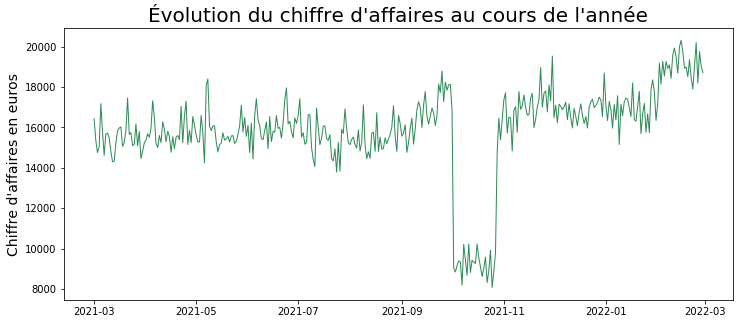

In [73]:
plt.figure(figsize=(12, 5))

table_gb_date = groupby_var(table, "date")

plt.plot(table_gb_date["date"], table_gb_date["price"], color="seagreen",
         label="Chiffre d'affaires", linewidth=1)

plt.title("Évolution du chiffre d'affaires au cours de l'année", fontsize=20)
plt.xlabel("")
plt.ylabel("Chiffre d'affaires en euros", fontsize=14)
plt.show()

On a une première approche de l'évolution du chiffre d'affaires global. On y observe une tendance à la hausse de cette évolution le long de l'année, progression interrompue entre les mois de septembre et novembre avec une forte chute du CA, avant une reprise normale de cette évolution dès novembre. Avant de continuer, distribuons cette courbe pour chaque catégorie de livres.

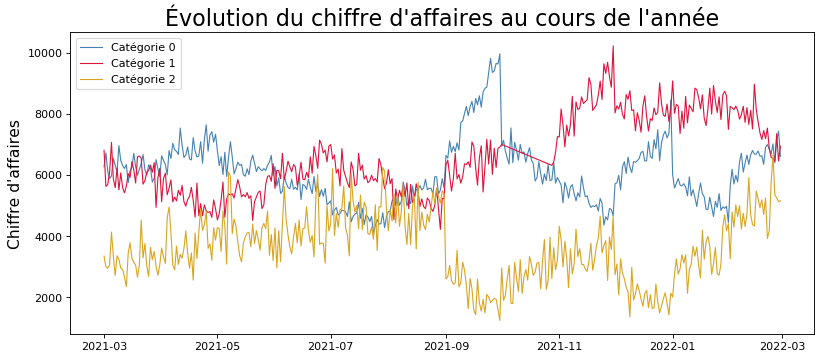

In [74]:
figure(num=None, figsize=(12, 5), dpi=80)

for i in range(3):
    cat=groupby_var(table.loc[table["categ"]==i], "date")
    color=couleur(i)
    plt.plot(cat["date"], cat["price"], color=color, linewidth=1, label= "Catégorie %d" %i)

plt.title("Évolution du chiffre d'affaires au cours de l'année", fontsize=20)
plt.xlabel("")
plt.ylabel("Chiffre d'affaires", fontsize=14)

plt.legend()
plt.show()

On observe une rentabilité globale moins élevée pour la catégorie 2. Mais remarquons surtout la chute du chiffre d'affaires des trois catégories de livres vers novembre. Essayons de voir ça de plus près en regroupant ces analyses par mois.

## I.2. Évolution mensuelle du chiffre d'affaires

On voit une chute entre les mois d'août et novembre sur le graphique précédent. Regardons ça de plus près avec une analyse mensuelle.

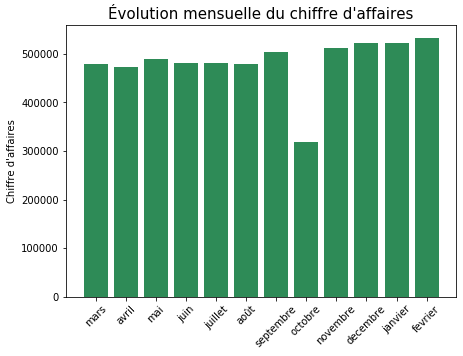

In [75]:
plt.figure(figsize=(7, 5))

emca = groupby_var(table, "mois")
emca["chronologie"]=emca["mois"].apply(chronologie)
emca=emca.sort_values(by="chronologie")

plt.bar(emca["mois"], emca["price"], color="seagreen")

plt.title("Évolution mensuelle du chiffre d'affaires", fontsize=15)
plt.xlabel("")
plt.ylabel("Chiffre d'affaires")
plt.xticks(rotation=45)
plt.show()

C'est ici qu'on repère la chute drastique du CA au mois d'octobre. Cela fera l'objet de notre prochaine partie. Tout d'abord, il serait intéressant d'analyser cet histogramme selon les 3 catégorie de livre.

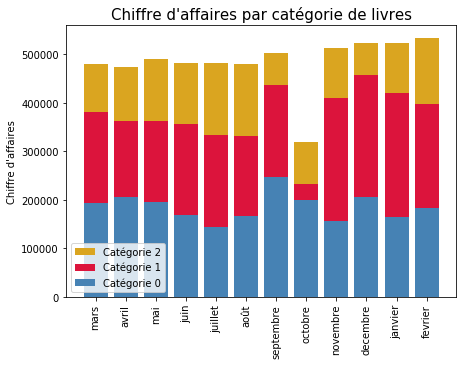

In [76]:
plt.figure(figsize=(7, 5))

eca=periode(table.pivot_table(index="mois",
                              columns="categ",
                              values="price",
                              aggfunc=sum).reset_index())
eca.columns=["mois", "categ_0", "categ_1", "categ_2"]

plt.bar(eca.mois, eca.categ_0+eca.categ_1+eca.categ_2, color=couleur(2), label="Catégorie 2")
plt.bar(eca.mois, eca.categ_0+eca.categ_1, color=couleur(1), label="Catégorie 1")
plt.bar(eca.mois, eca.categ_0, color=couleur(0), label="Catégorie 0")

plt.title("Chiffre d'affaires par catégorie de livres", fontsize=15)
plt.xlabel("")
plt.xticks(rotation = 'vertical')
plt.ylabel("Chiffre d'affaires")
plt.legend(loc="lower left")
plt.show()

On voit alors que c'est la catégorie 1 qui est la cause de la chute drastique du mois d'octobre.

## I.3. Observation du mois d'Octobre

Observons les ventes des livres au cours  du mois d'octobre.

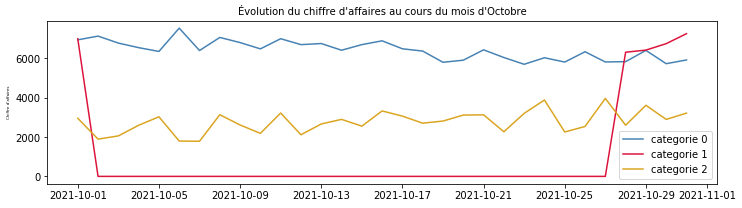

In [77]:
plt.figure(figsize=(12, 3))

octobre=table[table.mois=="octobre"].pivot_table(index=["date"],
                                                 columns=["categ"],
                                                 values=["price"],
                                                 aggfunc=sum).reset_index().fillna(0)
octobre.columns=["date", "categorie 0", "categorie 1", "categorie 2"]

for i in range(3):
    catego="categorie %d" %i
    plot(octobre["date"], octobre[catego], color=couleur(i), label=catego)
plt.title("Évolution du chiffre d'affaires au cours du mois d'Octobre", fontsize=10)
plt.xlabel("")
plt.ylabel("Chiffre d'affaires", fontsize=4)
plt.legend()
plt.show()

Effectivement, nous n'avons enregistré aucune vente entre le 2 et le 28 octobre inclus. Pourquoi? Faudra demander à la compta.

## I.4. Catégories de livres par nombre de ventes et par chiffre d'affaires

Nous allons tracer deux camemberts. Ils les parts des ventes selon les 3 catégories de livres, le premier selon le chiffre d'affaires, le deuxième selon les effectifs vendus.

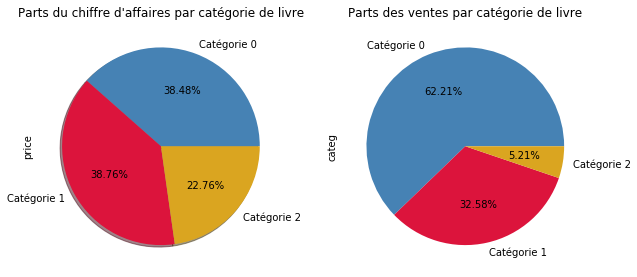

In [78]:
plt.figure(figsize=(10, 10))
plt.figure(1)

plt.subplot(2, 2, 1)
groupby_var(table, "categ")["price"].plot(kind="pie", colors=palette, labels=categories_3,
                                          autopct=lambda x: str(round(x, 2))+"%", shadow=True)
plt.title("Parts du chiffre d'affaires par catégorie de livre", fontsize=12)

plt.subplot(2, 2, 2)
table["categ"].value_counts(normalize=True).plot(kind="pie", colors=palette, labels=categories_3,
                                                 autopct=lambda x: str(round(x, 2))+"%")
plt.title("Parts des ventes par catégorie de livre", fontsize=12)

plt.show()

Comparaisons des deux diagrammes  circulaires:
- Les livres de la catégorie 0 sont ceux qui se vendent en plus grandes quantités mais ne représentent pas la plus grande part du chiffre d'affaires.
- Les livres de la catégorie 1 font la majeure partie du chiffre d'affaires, mais se vendent moins que la catégorie 0.
- Les livres de la catégorie 2 sont ceux qui se vendent le moins et participent le moins au chiffre d'affaires. Néanmoins, la comparaison entre le taux de ventes et la participation au chiffre d'affaires laisse supposer que ce sont globalement les livres les plus chers dans notre inventaire.

## I.5. Catégories de livres: Mesures de tendance centrale

Analysons les mesures de tendance centrales des recettes des trois catégories de livres dans des boîtes à moustaches.

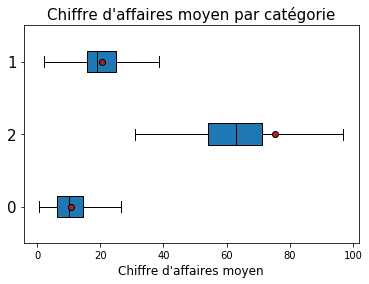

In [79]:
categories = table["categ"].unique()
categ_ca = []

for i in categories:
    categ_ca.append(table[table["categ"]==i]["price"])
    
plt.boxplot(categ_ca, labels=categories, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)

plt.title("Chiffre d'affaires moyen par catégorie", fontsize=15)
plt.xlabel("Chiffre d'affaires moyen", fontsize=12)
plt.ylabel("", fontsize=15)
plt.yticks(fontsize=15)
plt.show()

On constate alors que les prix sont beaucoup plus élevés pour les livres de la catégorie 2. La catégorie 1 propose également des prix plus importants que ceux de la catégorie 0. Il semblerait qu'il y ait une corrélation entre les prix et les catégories de livres.

# II. Statistiques de la clientèle

## II.2. Étude des âges

Tout d'abord, analysons les fréquences d'âge de nos clients.

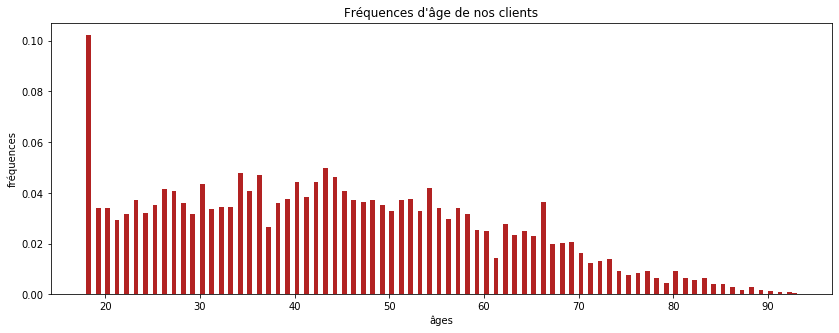

In [80]:
plt.figure(figsize=(14, 5))
plt.hist(customers["age"], density=True, width=0.5, bins=150, color="firebrick")
plt.title("Fréquences d'âge de nos clients")
plt.xlabel("âges")
plt.ylabel("fréquences")
plt.show()

La fréquence d'âge la plus forte chez nos clients est 18 ans. Les retraités se sentent de moins en moins concernés par nos produits. 50% de nos clients ont entre 30 et 55 ans. 25% ont moins de 30 ans et 25% ont plus de 55 ans.

## II.2. Étude des genres

Regardons maintenant les fréquences des genres de notre clientèle.

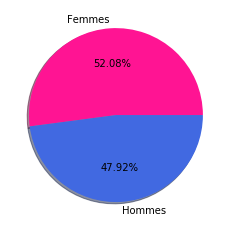

In [81]:
customers["sex"].value_counts().plot(kind="pie", colors=["deeppink", "royalblue"], labels=["Femmes", "Hommes"],
                                     autopct=lambda x: str(round(x, 2))+"%", shadow=True)
plt.ylabel("")
plt.show()

Regardons ces fréquences de genre par catégorie de livres.

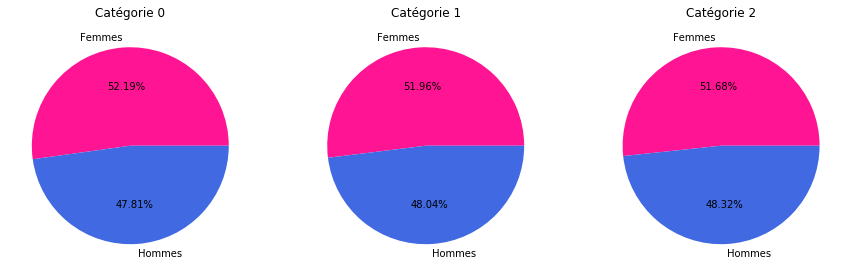

In [82]:
plt.figure(figsize=(15, 15))
plt.figure(1)

for i in table.categ.unique():
    
    clients_i = pd.DataFrame(table.loc[table.categ==i].groupby(["client_id", "sex"]).sum()["price"]).reset_index()
    clients_i.rename(columns={"price": "depenses"}, inplace=True)
    nb_achats_i = pd.DataFrame(table.loc[table.categ==i].client_id.value_counts()).reset_index()
    nb_achats_i.columns=["client_id", "nombre_livres_achetes"]
    clients_i=pd.merge(clients_i, nb_achats_i)
    
    plt.subplot(1, 3, i+1)
    clients_i["sex"].value_counts(normalize=True).plot(kind='pie', colors=["deeppink", "royalblue"], 
                                                       labels=["Femmes", "Hommes"], autopct=lambda x: str(round(x, 2))+"%")
    plt.title("Catégorie %s" %i)
    plt.ylabel("")
    
plt.show()

On peut admettre a priori que le genre du client ne conditionne pas la catégorie de livres à laquelle il/elle va s'intéresser.

## II.3. Répartition du chiffre d'affaires par client, courbe de Lorenz et indice de Gini

Nous allons étudier la répartition des fréquences d'achats selon les âges de nos clients.

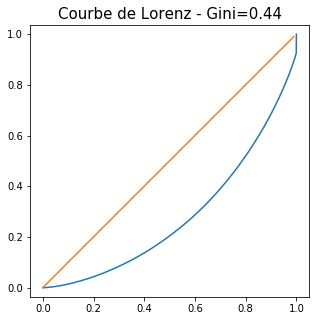

In [83]:
plt.figure(figsize=(5, 5))

clients=pd.DataFrame(table.groupby("client_id").sum()["price"]).sort_values("price")

depenses = clients.price.values
n = len(depenses)

lorenz = np.append([0], np.cumsum(depenses)/sum(depenses))
gini=2*(0.5-lorenz.sum()/n)
plt.axes().axis("equal")

plt.plot(np.linspace(0-1/n, 1+1/n, n+1), lorenz)
plt.title("Courbe de Lorenz - Gini=%s" %(round(gini, 2)), fontsize=15)

X = arange(0,1,0.01)
Y=X
plot(X, Y)
plt.show()

On observe alors sur la courbe de  Lorenz, avec un indice de Gini proche de  0,5 que la répartition du CA par client n'est pas égalitaire. 

## II.4. Proportions de clients actifs/inactifs

Il existe des clients enregistrés sur le site qui n'ont effectué aucun achat. On appelle "client actif" un client qui a effectué au moins un achat sur la période étudiée, "inactif" sinon.

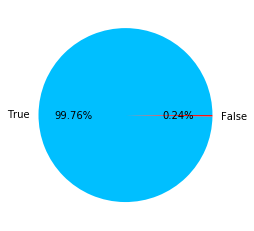

In [84]:
customers["is_active"]=customers["client_id"].isin(table.client_id)
customers["is_active"].value_counts(normalize=True).plot(kind="pie", 
                                                         colors=["deepskyblue", "red"],
                                                         autopct=lambda x: str(round(x, 2))+"%")
plt.ylabel("")
plt.show()

Donc un peu moins d'un client sur 400 s'enregistre mais n'effectue aucun achat.

# III. Statistiques des sessions d'achats

## III.1. Montants des sessions

Voyons comment a évolué la dépense moyenne des clients tout au long de l'année.

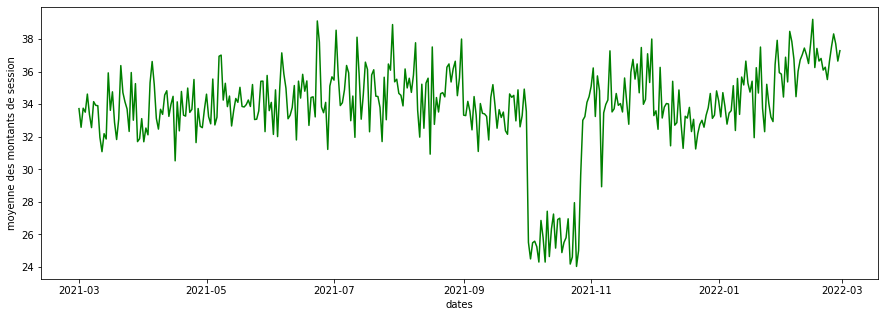

In [85]:
plt.figure(figsize=(15, 5))
year =  pd.DataFrame(sessions.groupby(["date"]).mean()["montant_session"]).reset_index()

plot(year.date, year.montant_session, color="green")

plt.xlabel("dates")
plt.ylabel("moyenne des montants de session")
plt.show()

On retrouve bien la même évolution que celle du chiffre d'affaires étudié en première partie. Observons maintenant cette évolution sur un mois, en prenant la moyenne de ce montant pour chaque jour de chaque mois observé,
en retirant le mois d'octobre en dépit de l'anomalie observé en première partie pour ne pas fausser les résultats.

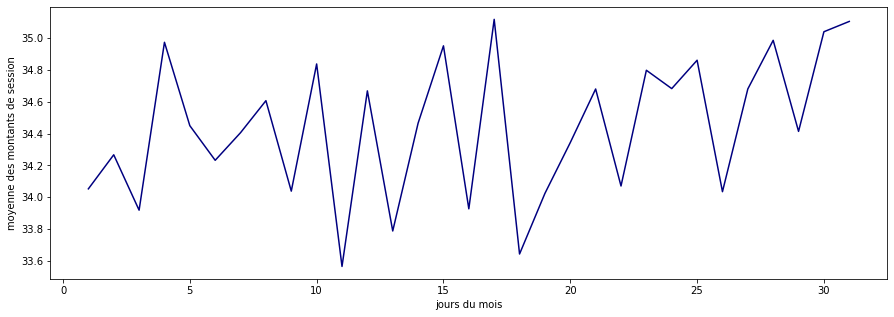

In [86]:
plt.figure(figsize=(15, 5))

mois =  pd.DataFrame(sessions.loc[sessions.mois!="octobre"].groupby(["jour"]).mean()["montant_session"]).reset_index()

plot(mois.jour, mois.montant_session, color="navy")
plt.xlabel("jours du mois")
plt.ylabel("moyenne des montants de session")
plt.show()

On observe en moyenne une tendance à la hausse au fil du mois. On peut  donc supposer que les clients effectuent généralement de plus gros  achats en  fin de mois. On repère ici les jours où les boosts de publicité à faire améliorerait nos ventes.

## III.2. Taille moyenne du panier

Une session d'achats regroupe parfois l'achat de plusieurs livres en même temps. On analyse ici la taille des paniers des transactions effectuées.

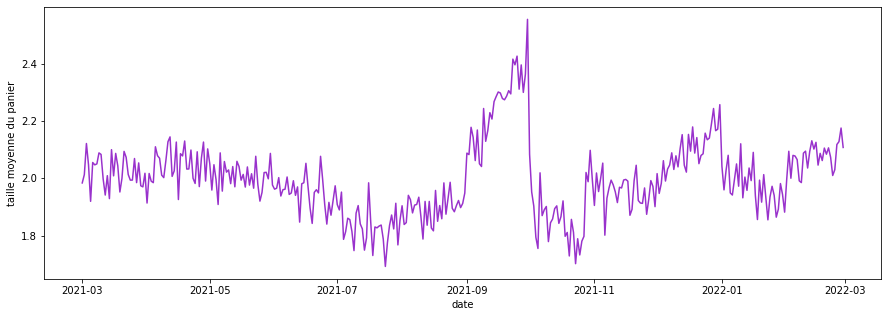

In [87]:
plt.figure(figsize=(15, 5))

panier_moyen = pd.DataFrame(sessions.groupby("date").mean()["taille_panier"]).reset_index()

plot(panier_moyen.date, panier_moyen.taille_panier, color="darkorchid")
plt.xlabel("date")
plt.ylabel("taille moyenne du panier")
plt.show()

Il est intéressant de noter que tout au long de l'année, la taille moyenne du panier des clients atteint son maximum journalier fin septembre, juste avant  la chuste drastique du chiffre d'affaires au mois d'octobre. Analysons-le maintenant l'évolution de la taille moyenne du panier par mois.

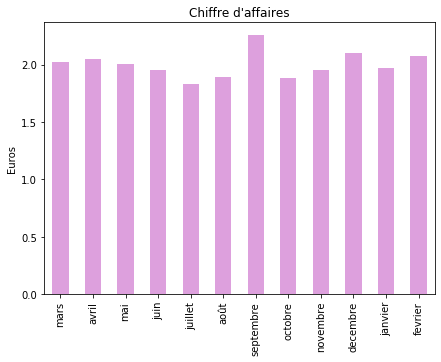

In [88]:
plt.figure(figsize=(7, 5))

panier_moyen_month = periode(pd.DataFrame(sessions.groupby("mois").mean()["taille_panier"]).reset_index())
panier_moyen_month = panier_moyen_month.set_index("mois")

panier_moyen_month["taille_panier"].plot.bar(color="plum")
plt.title("Chiffre d'affaires")
plt.xlabel("")
plt.ylabel("Euros")
plt.show()

Nous pouvons constater que le panier moyen est constant tous les mois, à peu de choses près. Le mois de septembre voit son panier moyen plus élevé que les autres, sans doute en vertue de la rentrée scolaire.

## III.3. Répartition du panier moyen

Regardons les fréquences de tailles des paniers.

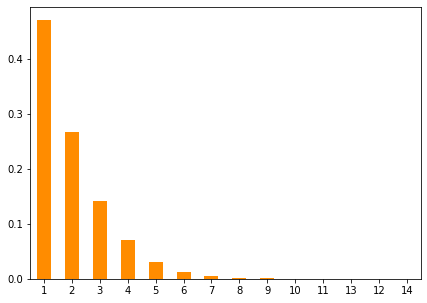

In [89]:
plt.figure(figsize=(7, 5))

sessions=sessions.sort_values("taille_panier")
sessions["taille_panier"].value_counts(normalize=True).plot(kind="bar", color="darkorange")
plt.xticks(rotation=0)
plt.show()

Une session cumule donc entre 1 et 14 articles vendus. On constate qu'environ la moitié des sessions n'enregistrent la vente que d'un seul livre. Bien entendu, plus la taille d'un panier est grande, plus se fréquence est faible dans le registre total des sessions d'achat. Il serait intéressant de voir la répartition des différentes tailles du panier lors des transactions.

# IV. Analyses des ventes et des prix

## IV.1. Bilan des prix

Analysons maintenant les étendues des prix pour les 3 catégories avec des boîtes à moustaches.

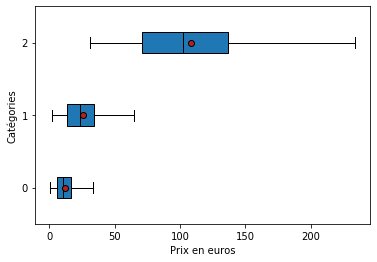

In [90]:
categories = products["categ"].unique()
categ_price = []

for i in categories:
    categ_price.append(products[products["categ"]==i]["price"])

plt.boxplot(categ_price, labels=categories, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.xlabel("Prix en euros")
plt.ylabel("Catégories")
plt.show()

- CATÉGORIE 0: Les prix varient entre 0,62 et 40,99 euros. En moyenne, ces livres coûtent environ 11,50 euros et la plupart d'entre eux se vendent à 4,99 euros. D'après le graphique ci-dessus, il s'agit de la catégorie "la moins chère".
- CATÉGORIE 1: Les prix varient entre 2 et 80,99 euros. En moyenne, ces livres coûtent environ 25,50 euros et la plupart d'entre eux se vendent à 22,99 euros. Cette catégorie semble s'adresser à tout poids de portefeuille.
- CATÉGORIE 2: Les prix varient entre 30,99 euros, et valent en moyenne environ 108,35 euros. La plupart d'entre eux coûtent 50,99 euros et d'après le graphique, il s'agit de la catégorie "la plus chère". Il s'agit également de la catégorie de livres proposant le choix le plus large au niveau des prix.

## IV.2. Vendus et invendus

Déterminons pour commencer la proportions de nos produits qui ne se sont pas vendus.

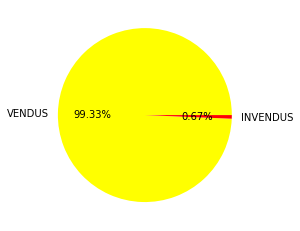

In [91]:
products["is_sold"]=products.id_prod.isin(table.id_prod)

products.loc[products.is_sold==True, "is_sold"]="VENDUS"
products.loc[products.is_sold==False, "is_sold"]="INVENDUS"

products.is_sold.value_counts(normalize=True).plot(kind="pie", 
                                                   colors=["yellow", "red"], autopct=lambda x: str(round(x, 2))+"%")
plt.ylabel("")
plt.show()

Donc nous avons plus d'un livre sur 200 qui ne se vend pas, ça va pas. Voyons ça par catégorie.

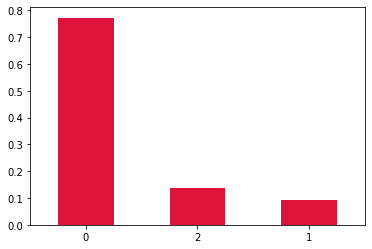

In [92]:
unsold = products[products.is_sold=="INVENDUS"]
unsold["categ"].value_counts(normalize=True).plot(kind="bar", color="crimson")
plt.xticks(rotation=0)
plt.show()

Va falloir revoir les commandes d'inventaire pour les livres de la catégorie 0.

## IV.3. Prix des invendus

Analysons maintenant les prix des invendus par rapport aux étendues de prix des livres qu'on vend.

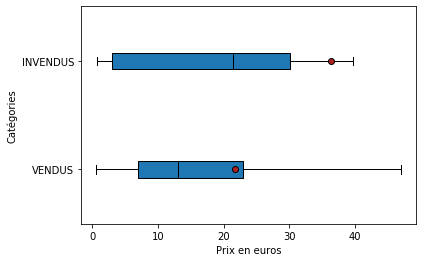

In [93]:
is_sold_or_not = products["is_sold"].unique()
price = []

for i in is_sold_or_not:
    price.append(products[products["is_sold"]==i]["price"])

plt.boxplot(price, labels=is_sold_or_not, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.xlabel("Prix en euros")
plt.ylabel("Catégories")
plt.show()

On peut voit clairement que les tendances centrales des vendus et des invendus ne sont pas les mêmes. Ce qui nous laisse supposer que certains livres sont trop chers pour susciter l'intérêt du client. Ainsi, la baisse immédiate des prix  des invendus de cette année serait susceptible faire vendre cette partie de nos produits pour l'année à venir.

# Mission 3: Étude des Corrélations

# I. Préparatifs et optimisations pour les analyses

## I.1. Fonctions utilitaires et identification des Outliers

Nous nous baserons également dans ce sujet sur le DataFrame "table", regroupant les transactions, les clients et les produits, où comme précédemment, nous y avons appliqué la fonction "entier" définie ci-dessous pour une plus belle présentation.

In [94]:
def entier(a):
    return int(a);

def round2(a):
    return round(a, 2);

#On donne, ici, la fonction eta_squared qui nous renvoie le rapport de corrélation entre une variable quantitative et une
#variable qualitative:
def eta_carre(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

Nous allons également créer sur les tableaux de support la variable "tranche" pour "tranches d'âges", qui nous renverra trois catégories différentes selon l'âge  du  clients. Mon choix des intervalles de ces trois tranches d'âges résulte d'une première analyse des corrélations demandées, où je me suis aperçu que l'on pouvait reconsidérer certaines corrélations si l'on regroupait  les clients par ces trois tranches d'âges. La variable quantitative  "tranche" renverra:
- "edtudiant" si le client est âgé de 30 ans ou moins.
- "actif" si le client est âgé de 31 à 50 ans.
- "senior" si le client est âgé de 51 ans ou plus.

Le choix des noms "etudiant", "actif" et "senior" est purement indicatif, ne considérons pas pour autant un individus de 51 ans comme un sénior dans la réalité!

In [95]:
def get_tranche(a):
    if a<=30: return("etudiant")
    elif a<=50: return("actif")
    else: return("senior")

Nous avons vu dans la partie II.2 de la mission 2 que les clients de 18 ans étaient en surplus par rapport aux autres. Nous les considérerons donc comme des Outliers pour une analyse plus objective sur les âges des clients. Nous les retirerons donc de nos données.

In [96]:
def drop_18(data):
    return(data.loc[data.age!=18])

Aussi, en constatant certaines dépenses exhorbitantes lors de cette même mission 2, nous pouvons fortement supposer que certains clients s'approvisionnent chez nous pour le compte d'une entreprise. Nous les identifierons à nouveau ci-dessous afin de les supprimer de nos tableaux pour des résultats plus objectifs sur nos clients et leurs tendances d'achats mêmes.

In [97]:
def sup_depenses(data, p):
    return(data[data["depense_annuelle"]>p][["client_id", "depense_annuelle"]])

## I.2. Tableaux de support et suppression des Outliers

On reprendra notre DataFrame "table" définit en fin de mission 1 pour diverses analyses des corrélations à venir. Nous retirons donc les clients de plus de 18 ans de nos données et nous ajoutons la colonne "tranche" au DataFrame définie précédemment.

In [98]:
# Suppression des clients âgés de 18 ans:
table=drop_18(table)

# Ajout de la colonne "tranche":
table["tranche"]=table["age"].apply(get_tranche)

table=table.reset_index(drop=True)
table.head(3)

,id_prod,categ,price,client_id,sex,age,session_id,basket_size,date,mois,jour,heure,tranche
0,0_2007,0,9.99,c_6906,m,36,s_201,3,2021-03-01,mars,1,10:06:06,actif
1,0_2096,0,14.84,c_6823,m,64,s_311,2,2021-03-01,mars,1,14:54:32,senior
2,0_1627,0,3.99,c_6823,m,64,s_72,1,2021-03-01,mars,1,02:58:10,senior


Nous nous servirons également du DataFrame "clients" définie ci-dessous qui, basée sur "table", regroupe les données par clients, et renvoie le montant total de ce qu'ils ont dépensés en un an, ainsi que le nombre total de livres qu'ils ont achetés, toutes sessions confondues.

In [99]:
# Création du DataFrame "clients":
clients = pd.DataFrame(table.groupby(["client_id", "sex", "age"]).sum()["price"]).reset_index()
clients.rename(columns={"price": "depense_annuelle"}, inplace=True)
nb_achats = pd.DataFrame(table["client_id"].value_counts()).reset_index()
nb_achats.columns=["client_id", "nombre_livres_achetes"]
clients=pd.merge(clients, nb_achats)

# Suppression des Outliers et ajout de la colonne "tranche":
clients=drop_18(clients)
clients["tranche"]=clients["age"].apply(get_tranche)

clients=clients.reset_index(drop=True)
clients.head(3)

,client_id,sex,age,depense_annuelle,nombre_livres_achetes,tranche
0,c_1,m,67,300.65,20,senior
1,c_10,m,66,586.18,28,senior
2,c_100,m,30,222.87,6,etudiant


Observons les clients ayant dépensés plus de 1000 euros sur un an.

In [100]:
sup_depenses(clients, 1000)

,client_id,depense_annuelle
4,c_1001,1102.45
9,c_1006,1925.49
15,c_1011,1042.30
17,c_1013,1291.99
18,c_1014,1427.90
...,...,...
8125,c_961,1382.64
8126,c_963,2191.49
8146,c_983,1372.68
8153,c_990,1642.00


Nous en observons un nombre trop important pour tous les considérer comme des Outliers. Fixons-nous un seuil de 3000 euros.

In [101]:
sup_depenses(clients, 3000)

,client_id,depense_annuelle
640,c_1609,162007.34
2590,c_3454,54462.90
4184,c_4958,144257.21
6021,c_6714,73217.32


On cible alors 4 clients qui ont dépensé plus de 50 mille euros en un an, et on peut admettre que les autres ont dépensé moins de 3000 euros. Ces 4 clients identifiés seront donc reconnus comme des Outliers et nous les retirons de nos données.

In [102]:
clients=clients[clients.depense_annuelle<3000].reset_index(drop=True)
clients

,client_id,sex,age,depense_annuelle,nombre_livres_achetes,tranche
0,c_1,m,67,300.65,20,senior
1,c_10,m,66,586.18,28,senior
2,c_100,m,30,222.87,6,etudiant
3,c_1000,f,56,980.02,56,senior
4,c_1001,m,40,1102.45,58,actif
...,...,...,...,...,...,...
8154,c_995,m,67,119.08,8,senior
8155,c_996,f,52,739.60,42,senior
8156,c_997,f,28,572.89,23,etudiant
8157,c_998,m,21,1527.69,28,etudiant


Nous retirons également ces clients du DataFrame "table" et nous allons enfin pouvoir entammer l'analyse des corrélations.

In [103]:
table=table.loc[table["client_id"].isin(clients["client_id"])==True]
table

,id_prod,categ,price,client_id,sex,age,session_id,basket_size,date,mois,jour,heure,tranche
0,0_2007,0,9.99,c_6906,m,36,s_201,3,2021-03-01,mars,1,10:06:06,actif
1,0_2096,0,14.84,c_6823,m,64,s_311,2,2021-03-01,mars,1,14:54:32,senior
2,0_1627,0,3.99,c_6823,m,64,s_72,1,2021-03-01,mars,1,02:58:10,senior
3,2_108,2,63.36,c_5042,m,27,s_314,1,2021-03-01,mars,1,15:03:55,etudiant
4,1_446,1,23.92,c_5890,m,65,s_109,1,2021-03-01,mars,1,04:34:54,senior
...,...,...,...,...,...,...,...,...,...,...,...,...,...
329463,0_1152,0,10.70,c_332,f,49,s_172145,5,2022-02-28,fevrier,28,10:31:46,actif
329464,0_2134,0,5.57,c_903,f,59,s_171999,1,2022-02-28,fevrier,28,03:26:03,senior
329465,0_2293,0,4.99,c_2048,m,35,s_171940,7,2022-02-28,fevrier,28,01:05:47,actif
329466,0_1140,0,3.73,c_8547,f,45,s_171986,1,2022-02-28,fevrier,28,02:43:12,actif


## I.3. Autres supports

Créons la table "mean_purchase_month" qui affiche la moyenne du nombre d'achats par mois pour chaque client avec leur âge.

In [121]:
mean_purchase_month = table.pivot_table(index=["client_id", "age", "tranche"],
                          columns=["mois"],
                          values=["basket_size"],
                          aggfunc=sum)
mean_purchase_month=mean_purchase_month.fillna(0)
mean_purchase_month["mean_purchaseamonth"]=mean_purchase_month.mean(axis=1)
mean_purchase_month["mean_purchaseamonth"]=mean_purchase_month.mean_purchaseamonth.apply(round2)
mean_purchase_month=mean_purchase_month.reset_index()

mean_purchase_month.columns=["client_id", "age", "tranche",
                "x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9", "x10", "x11", "x12",
               "mean_purchaseamonth"]

mean_purchase_month.drop(columns=["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9", "x10", "x11", "x12"], inplace=True)
mean_purchase_month.head(3)

,client_id,age,tranche,mean_purchaseamonth
0,c_1,67,senior,3.50
1,c_10,66,senior,5.83
2,c_100,30,etudiant,1.17


 Remarquons la présence de quelques Outliers.

In [124]:
len(mean_purchase_month[mean_purchase_month.mean_purchaseamonth>50])

11

 Sur 8600 clients, seuls 11 ont une moyenne d'achat par mois supérieure à 50. Pour donner un indice de corrélation plus fiable, on peut néglier ces 15 éléments en question.

In [125]:
mean_purchase_month=mean_purchase_month[mean_purchase_month.mean_purchaseamonth<=50]
mean_purchase_month

,client_id,age,tranche,mean_purchaseamonth
0,c_1,67,senior,3.50
1,c_10,66,senior,5.83
2,c_100,30,etudiant,1.17
3,c_1000,56,senior,9.17
4,c_1001,40,actif,15.67
...,...,...,...,...
8154,c_995,67,senior,1.17
8155,c_996,52,senior,4.50
8156,c_997,28,etudiant,5.75
8157,c_998,21,etudiant,9.67


 Enfin, créons le DataFrame "panier", à partir de "table", afin d'avoir un tableau nous donnant chaque identifiant de client avec son âge et la taille moyenne de ses paniers pour l'ensemble de ses achats.

In [128]:
panier = pd.DataFrame(table.groupby(["client_id", "age", "tranche"]).mean()["basket_size"]).reset_index()
panier.rename(columns={"basket_size": "panier_moyen"}, inplace=True)
panier["panier_moyen"]=panier["panier_moyen"].apply(round2)
panier

,client_id,age,tranche,panier_moyen
0,c_1,67,senior,2.10
1,c_10,66,senior,2.50
2,c_100,30,etudiant,2.33
3,c_1000,56,senior,1.96
4,c_1001,40,actif,3.24
...,...,...,...,...
8154,c_995,67,senior,1.75
8155,c_996,52,senior,1.29
8156,c_997,28,etudiant,3.00
8157,c_998,21,etudiant,4.14


# II. Sexe des clients et catégories de produits achetés

## II.1. Tableau de contingence réel

 Nous cherchons, ici, à savoir si les hommes ou les femmes s'orientent plus vers telle ou telle catégorie  de livres. Créons dans un premier temps le tableau de contingence réel.

In [104]:
c=table[["categ", "sex"]].pivot_table(index="categ",
                              columns="sex",
                              aggfunc=len)

cont =  c.copy()

tx = table["categ"].value_counts()
ty = table["sex"].value_counts()

cont.loc[:, "Total"] = tx
cont.loc["total", :] = ty
cont.loc["total", "Total"] = len(table)
cont

sex,f,m,Total
categ,,,
0,100279.0,93323.0,193602.0
1,52359.0,47507.0,99866.0
2,6630.0,6205.0,12835.0
total,159268.0,147035.0,306303.0


 Pour le moment, nous ne semblons pas distinguer de corrélations significatives. Mais la construction du tableau de contingence théorique en vue du tableau de contingence coloré peut contredire cette supposition.

## II.2. Tableau de contingence théorique

 Créons maintenant le tableau de contingence théorique en vue d'un test des éventuelles corrélations.

In [105]:
tx = pd.DataFrame(tx)
ty = pd.DataFrame(ty)

tx.columns=["foo"]
ty.columns=["foo"]

n = len(table)
indep =  tx.dot(ty.T)/n

indep.sort_index(axis=1, inplace=True)
indep.sort_index(inplace=True)

indep

,f,m
0,100666.997502,92935.002498
1,51927.203090,47938.796910
2,6673.799408,6161.200592


 Mesurons alors le Chi-2, le degré de liberté et la p_value.

In [106]:
mesure = (c-indep)**2/indep

xi_n = mesure.sum().sum()
ddl = (len(c)-1)*(len(c.columns)-1)
pvalue = st.chi2_contingency(c)[1]

print("Degré de liberté:", ddl)
print("p_value:", round(pvalue, 20))
print("Chi-2:", xi_n)

Degré de liberté: 2
p_value: 0.003708960918746871
Chi-2: 11.194007034801633


 On s'aperçoit que la p_value est très proche de  0. Ce qui nous permet de rejeter l'hypothèse qu'il n'y a aucune indépendance entre le genre du client et les catégories de produits. On en déduit donc qu'il y a bien une corrélation entre le sexe des clients et les catégories de produits achetés.

## II.3. Tableau de contingence coloré

 Analysons maintenant cette corrélation pour chacune des 3 catégories de livre avec un tableau de contingence coloré.

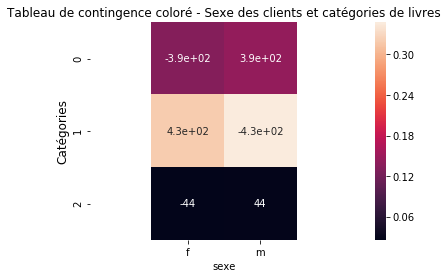

In [107]:
sns.heatmap(mesure/xi_n, annot=c-indep)
plt.title("Tableau de contingence coloré - Sexe des clients et catégories de livres")
plt.xlabel("sexe")
plt.ylabel("Catégories", fontsize=12)
plt.axis("equal")
plt.show()

 __Conclusion:__
- Catégorie 0: Il y a une légère corrélation, en effet, les hommes semblent s'intéresser plus à cette catégorie de livres que les femmes.
- Catégorie 1: Il y a corrélatation entre cette catégorie de livres et le genre du client. On voit ici que cette catégorie intéresse beaucoup plus les femmes que les hommes.
- Catégorie 2: Le genre du client importe peu. Les femmes s'intéressent aussi fréquemment à cette catégorie de livres que les hommes.

# III. Âge des clients et montant total des achats

## III.1. Diagramme de dispersion

 Nous nous baserons, cette fois-ci, sur les colonnes "age" et "depense_annuelle" du DataFrame "clients" définit en introduction de la mission 3.

In [109]:
clients[["client_id", "age", "depense_annuelle"]]

,client_id,age,depense_annuelle
0,c_1,67,300.65
1,c_10,66,586.18
2,c_100,30,222.87
3,c_1000,56,980.02
4,c_1001,40,1102.45
...,...,...,...
8154,c_995,67,119.08
8155,c_996,52,739.60
8156,c_997,28,572.89
8157,c_998,21,1527.69


 Déterminons maintenant le diagramme de dispersion entre l'âge des clients et le montant total des achats, la droite de régression linéaire de ce diagramme, ainsi que le coefficient de corrélation de Pearson afin d'avaluer s'il y a bien corrélation entre ces deux variables quantitatives.

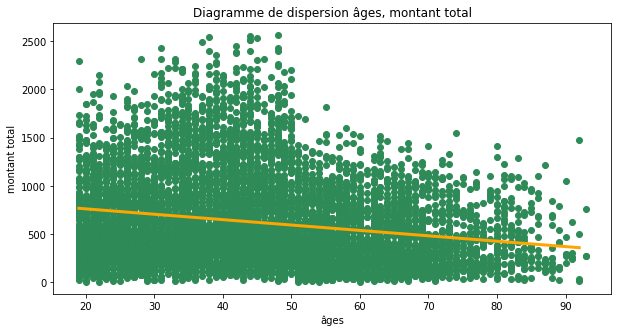

Coefficient de corrélation de Pearson: -0.19835769852758453
Sa p_value est de: 3.52634844253707e-73


In [115]:
plt.figure(figsize=(10, 5))

#Calculs des paramètres a et b de la droite de régression linéaire (coefficient directeur et ordonnée à l'origine):
X=clients[["age"]]
Y=clients["depense_annuelle"]
X = X.assign(intercept = [1]*len(X))
lr = sm.OLS(Y, X).fit()
a = lr.params["age"]
b = lr.params["intercept"]

#Ici, on détermine l'intervalle d'affichage de cette droite:
X=clients["age"]
fenetre=np.arange(min(X), max(X))

#On affiche maintenant le diagramme de dispersion accompagné de cette fameuse droite:
plt.plot(X, Y,  "o", color="seagreen")
plt.plot(fenetre, [a*x+b for x in fenetre], color="orange", linewidth=3)
plt.title("Diagramme de dispersion âges, montant total")
plt.xlabel("âges")
plt.ylabel("montant total")
plt.show()

#Enfin, on affichera juste en-dessous le coefficient de corrélation de Pearson de ces deux variables et sa p_value:
pearson = st.pearsonr(X, Y)[0]
p_value = st.pearsonr(X, Y)[1]
print("Coefficient de corrélation de Pearson:", pearson)
print("Sa p_value est de:", p_value)

 Ce nuage de points nous laisse supposer, qu'il existe une corrélation négative entre l'âge des clients et le montant total des dépenses. À la vue de la "pente" de la droite de régression linéaire (coefficient directeur négatif) et par le calcul d'un coefficient de corrélation de Pearson proche de -0,2, on en conclue que l'on peut supposer une corrélation négative faible entre l'âge des clients et le montant total des achats: Plus un client est âgé, moins il dépense chez nous en un an. Cependant, aucune fonction affine à coefficient directeur négatif ne se dégage vraiment de ce nuage de  points si l'on analyse  le graphique sans le traçage  de la droite de régression linéaire. On observe d'ailleurs que les clients âgés d'entre 31 et 50 ans semblent dépenser plus que les moins de 30 ans, alors qu'on avait supposé une corrélation négative. Il serait donc plus judicieux d'étudier la corrélation entre les trois tranches d'âges des clients prédéfinies en introduction et le montant total des achats.

## III.2. Tranches d'âges et montant des achats

 C'est par l'intermédiaire de boîtes à moustaches qu'on va vérifier s'il y a corrélation entre les trois tranches d'âges prédéfinies et la dépense annuelle.

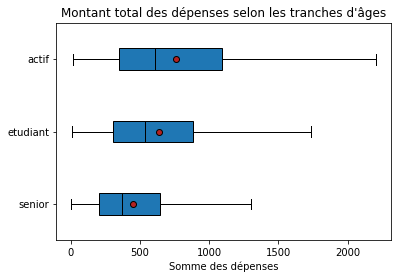

Rapport de corrélation: 8.9


In [116]:
tranches = clients["tranche"].unique()
tranche_montant = []

for i in tranches:
    tranche_montant.append(clients[clients["tranche"]==i]["depense_annuelle"])
    
plt.boxplot(tranche_montant, labels=tranches, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title("Montant total des dépenses selon les tranches d'âges")
plt.xlabel("Somme des dépenses")
plt.ylabel("")
plt.show()
print("Rapport de corrélation:", 100*round(eta_carre(clients["tranche"], clients["depense_annuelle"]), 3))

 Les moyennes de ces trois bloxplots semblent presque homogène. Avec un rapport de corrélation d'environ 8,9%, on peut en déduire une corrélation moyenne entre les tranches d'âges et le montant total des dépenses: Les "actifs" semblent  dépenser légèrement plus que les étudiants qui, eux, dépensent plus que les seniors.

# IV. Âge des clients et fréquences d'achats

## IV.1. Diagramme de dispersion

 Ici, c'est la table "mean_purchase_month" qui nous sera utile. Elle renvoie la fréquence moyenne du nombre d'achats par mois de chaque client. Analysons le diagramme de dispersion en question.

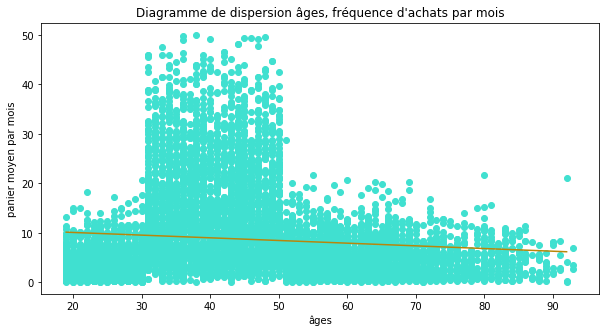

Coefficient de corrélation de Pearson: -0.09881656419486055
Sa p_value est de: 3.8803778103577546e-19


In [130]:
plt.figure(figsize=(10, 5))

#Calculs des paramètres a et b de la droite de régression linéaire (coefficient directeur et ordonnée à l'origine):
X=mean_purchase_month[["age"]]
Y=mean_purchase_month["mean_purchaseamonth"]
X = X.assign(intercept = [1]*len(X))
lr = sm.OLS(Y, X).fit()
a = lr.params["age"]
b = lr.params["intercept"]

#Ici, on détermine l'intervalle d'affichage de cette droite:
X=mean_purchase_month["age"]
fenetre=np.arange(min(X), max(X))

#On affiche maintenant le diagramme de dispersion accompagné de cette fameuse droite:
plt.plot(X, Y,  "o", color="turquoise")
plt.plot(fenetre, [a*x+b for x in fenetre], color="darkgoldenrod")
plt.title("Diagramme de dispersion âges, fréquence d'achats par mois")
plt.xlabel("âges")
plt.ylabel("panier moyen par mois")
plt.show()

#Enfin, on affichera juste en-dessous le coefficient de corrélation de Pearson de ces deux variables et sa p_value:
pearson = st.pearsonr(X, Y)[0]
p_value = st.pearsonr(X, Y)[1]
print("Coefficient de corrélation de Pearson:", pearson)
print("Sa p_value est de:", p_value)

 Malgré un coefficient de Pearson proche de  0, le nuage de points semble  indiquer une éventuelle corrélation entre  l'âge des clients et la fréquence d'achats: Les clients âgés de 31 à 50 effectuent plus d'achats chaque mois, que les tranches d'âges inférieure et supérieure. 

## IV.2. Tranches d'âges et fréquences d'achats

 Il serait alors très intéressant de se demander s'il y a corrélation entre les tranches d'âges des  clients et cette  fréquence  d'achats.

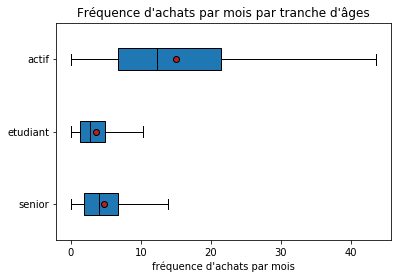

Rapport de corrélation: 0.35146676841422303


In [131]:
#On s'intéresse aux tranches d'âges présentes parmi les mean_purchase_month ayant effectué des achats dans chacune de nos 3 catégories de
#produits:

tranches = mean_purchase_month["tranche"].unique()
frequence = []

for i in tranches:
    frequence.append(mean_purchase_month[mean_purchase_month["tranche"]==i]["mean_purchaseamonth"])

plt.boxplot(frequence, labels=tranches, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title("Fréquence d'achats par mois par tranche d'âges")
plt.xlabel("fréquence d'achats par mois")
plt.ylabel("")
plt.show()

print("Rapport de corrélation:", eta_carre(mean_purchase_month["tranche"], mean_purchase_month["mean_purchaseamonth"]))

 Notre supposition est vérifiée. Avec un rapport de corrélation très fort d'environ 35%, on peut fortement suggérer que les clients âgés d'entre 31 et 50 ans dépensent plus par mois que les deux autres tranches d'âges, à peu près équivalentes entre elles à ce niveau-là.

# V. Âge des clients et taille du panier moyen

## V.1. Diagramme de dispersion

Le DataFrame "panier" nous renvoie la taille moyenne des paniers des clients à l'issue des sessions d'achats. C'est sur celui-ci que nous traçons le diagramme de dispersion.

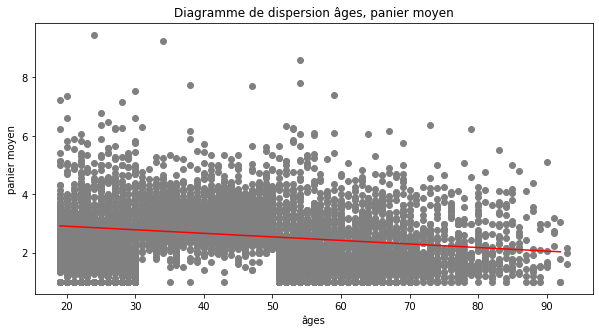

Coefficient de corrélation de Pearson: -0.20603163055087242
Sa p_value est de: 6.307268714623795e-79


In [133]:
plt.figure(figsize=(10, 5))

#Calculs des paramètres a et b de la droite de régression linéaire:
X=panier[["age"]]
Y=panier["panier_moyen"]
X = X.assign(intercept = [1]*len(X))
lr = sm.OLS(Y, X).fit()
a = lr.params["age"]
b = lr.params["intercept"]

#Intervalle d'affichage de cette droite:
X=panier["age"]
fenetre=np.arange(min(X), max(X))

#On affiche maintenant le diagramme de dispersion accompagné de cette fameuse droite:
plt.plot(X, Y,  "o", color="grey")
plt.plot(fenetre, [a*x+b for x in fenetre], color="r")
plt.title("Diagramme de dispersion âges, panier moyen")
plt.xlabel("âges")
plt.ylabel("panier moyen")
plt.show()

#Enfin, on affichera juste en-dessous le coefficient de corrélation de Pearson de ces deux variables:
pearson = st.pearsonr(X, Y)[0]
p_value = st.pearsonr(X, Y)[1]
print("Coefficient de corrélation de Pearson:", pearson)
print("Sa p_value est de:", p_value)

Ce nuage de points nous laisse supposer, qu'il existe une corrélation négative entre l'âge des clients et le panier moyen. À la vue de la "pente" de la droite de régression linéaire (coefficient directeur négatif) et par le calcul d'un coefficient de corrélation de Pearson proche de -0,2, on en conclue qu'il existe une corrélation négative faible entre l'âge des clients et le panier moyen. L'absence  de points dans le rectangle [31; 50]x[0; 2] nous laisse penser que le panier moyen est globalement plus élevés chez  les  actifs. Comme pour la question 3, il ne se dégage aucune régression linéaire de ce nuage de points. C'est pourquoi nous allons encore une fois réétudier cette corrélation, cette fois-ci avec les tranches d'âges.

## V.2. Tranches d'âges et taille du panier moyen

Les boîtes à moustaches suivantes nous donneront un indice de cette éventuelle corrélation.

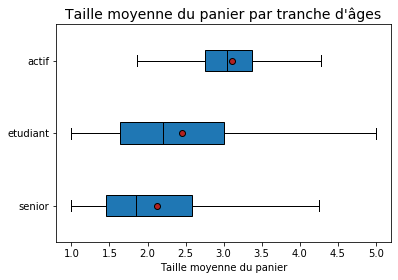

Rapport de corrélation: 20.8 %


In [134]:
tranches = panier["tranche"].unique()
size = []

for i in tranches:
    size.append(panier[panier["tranche"]==i]["panier_moyen"])

plt.boxplot(size, labels=tranches, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title("Taille moyenne du panier par tranche d'âges", fontsize=14)
plt.xlabel("Taille moyenne du panier")
plt.ylabel("")
plt.show()

print("Rapport de corrélation:", 100*round(eta_carre(panier["tranche"], panier["panier_moyen"]), 3), "%")

Le  rapport de  corrélation est supérieur  à 20%. On peut donc, à  la  vue  des boîtes, fortement  supposer une  corrélation simillaire à la celle de la question précédente: le panier moyen semble être plus élevés chez les personnes âgés d'entre 31 et 50  ans.

# VI. Âge des clients et catégories de produits achetés

## VI.1. Rapport de corrélation

Cette fois-ci, on reprend notre DataFrame initial "table" sur lequel on analyse les éventuelles corrélations entre les âges des clients et les catégories de produits achetés.

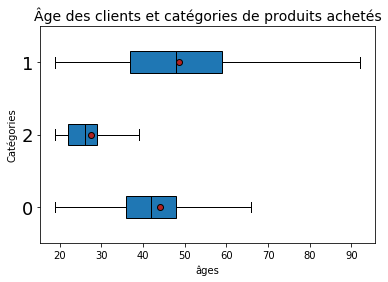

Rapport de corrélation: 9.9 %


In [136]:
categories = table["categ"].unique()
categ_ages = []

for i in categories:
    categ_ages.append(table[table["categ"]==i]["age"])
    
plt.boxplot(categ_ages, labels=categories, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title("Âge des clients et catégories de produits achetés", fontsize=14)
plt.xlabel("âges")
plt.ylabel("Catégories")
plt.yticks(fontsize=18)
plt.show()
print("Rapport de corrélation:", 100*round(eta_carre(table["categ"], table["age"]), 3), "%")

Avec un rapport de corrélation d'environ 10%, on peut donc sereinement qu'il y a corrélation entre  l'âge des clients et les catégories de produits achetés: on remarque que la boîte à moustaches de la catégorie 2 diffère bien des deux autres, plus rapprochées. La catégorie 2 s'adresse globalement à une clientèle plus jeune, entre 18 et 25 ans, notamment, tandis que les moyennes d'âge des catégorie 0 et 1 semblent plus homogènes, et intéressent apparemment tout type de client, quelque soit l'âge.

## VI.2. Tranches d'âges et montant des achats

Afin d'appuyer nos suppositions, nous allons, une dernière fois, vérifier les potentielles corrélations entre les catégories de produits achetées et variable qualitative "tranche". Cette fois-ci, il s'agit donc de l'étude entre deux variables qualitatives, nous revenons donc au fameux tableau de contingence coloré.

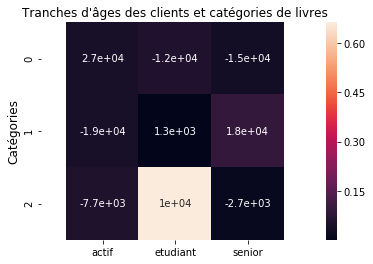

pvalue: 0.0
Chi-2: 133068.47242487533


In [138]:
c = table[["categ", "tranche"]].pivot_table(index="categ",
                              columns="tranche",
                              aggfunc=len)
cont =  c.copy()
tx = table["categ"].value_counts()
ty = table["tranche"].value_counts()
cont.loc[:, "Total"] = tx
cont.loc["total", :] = ty
cont.loc["total", "Total"] = len(table)
tx = pd.DataFrame(tx)
ty = pd.DataFrame(ty)
tx.columns=["foo"]
ty.columns=["foo"]
n = len(table)
indep =  tx.dot(ty.T)/n
indep.sort_index(axis=1, inplace=True)
indep.sort_index(inplace=True)
mesure = (c-indep)**2/indep
xi_n = mesure.sum().sum()
ddl = (len(c)-1)*(len(c.columns)-1)
pvalue = st.chi2_contingency(c)[1]
sns.heatmap(mesure/xi_n, annot=c-indep)

plt.title("Tranches d'âges des clients et catégories de livres")
plt.xlabel("")
plt.ylabel("Catégories", fontsize=12)
plt.axis("equal")
plt.show()
print("pvalue:", pvalue)
print("Chi-2:", xi_n)

On observe finalement bien la corrélation supposée précédemment: Avec un pvalue nulle et un Chi-2 de 100 mille d'ordre de grandeur, on peut affirmer sans crainte que les étudiants s'intéressent beaucoup plus à la catégorie 2 que les actifs et les seniors. Pour les catégories 0 et 1, l'âge du client importe peu: tous semblent semblent porter à peu près le même degré d'intérêt pour chacune de ces deux catégories, qu'ils soient étudiants, actifs ou seniors.